In [1]:
import sys
sys.path.append('../')
from read_data_functions import *
from plot_functions import *
from calculations import *
plt.style.use('../Style.mplstyle')
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # suppress warnings

In [2]:
path = '../../../Data/2025/250929-251003_Ulva/'
gcms_raw = import_data(f'{path}GC-MS/', '', None, None, None)
gcms_raw = gcms_raw['250929-251003_Ulva_results']
flow_data = import_data(f'{path}Absorbent tube flows/', '', 'Time', '%d-%m-%Y %H:%M:%S', 0)

In [37]:
timestamps = [['2025-09-29 17:11', '2025-09-29 19:11'],   # [P] = 3.9 uM, R1
              
              ['2025-09-30 09:37', '2025-09-30 11:34'],   # Blank1
              ['2025-09-30 12:41', '2025-09-30 14:38'],   # [P] = 0.02 uM, R2
              ['2025-09-30 16:15', '2025-09-30 18:14'],   # [P] = 19 uM, R1 

              ['2025-10-01 09:33', '2025-10-01 11:31'],   # [P] = 3.9 uM, R2
              ['2025-10-01 12:44', '2025-10-01 14:46'],   # Blank2
              ['2025-10-01 15:49', '2025-10-01 17:49'],   # [P] = 0.7 uM, R2

              ['2025-10-02 09:53', '2025-10-02 12:06'],   # [P] = 19 uM, R2
              ['2025-10-02 13:24', '2025-10-02 15:27'],   # [P] = 3.9 uM, R3
              ['2025-10-02 16:52', '2025-10-02 18:57'],   # [P] = 0.02 uM, R3

              ['2025-10-03 10:01', '2025-10-03 12:03'],   # [P] = 0.7 uM, R3  
              ['2025-10-03 13:18', '2025-10-03 15:17'],   # [P] = 19 uM, R3
              ['2025-10-03 16:59', '2025-10-03 18:59']    # Blank3
]

flow_keys = ['250929_P39_Ulva_A028727T_A028689C', 
             '250930_Blank1_Ulva_A029641T_A028596C', '250930_P002_Ulva_A028572T_A028052C', '250930_P19_Ulva_A028476T_A030827C', 
             '251001_P39_Ulva_A029668T_A030947C', '251001_Blank2_Ulva_A030818T_A031826C', '251001_P07_Ulva_A028453T_A029151C',
             '251002_P19_Ulva_A029717T_A029836C', '251002_P39_Ulva_A028586T_A029651C', '251002_P002_Ulva_A029658T_A030854C',
             '251003_P07_Ulva_A029817T_A029691C', '251003_P19_Ulva_A029803T_A028597C', '251003_Blank3_Ulva_A029154T_A028440C']

gcms = GCMS_concentration_calculation(flow_data, flow_keys, ' Flow [L/min]', timestamps, gcms_raw, 'TA and CA', 0.5)

P_concentrations = []
for index in gcms.index:
    P_conc = index.split('_')[2]
    P_concentrations.append(P_conc.split('-')[0])
gcms['P concentration'] = P_concentrations

# Drymatter content in g
drymatter_content = [[0.2679, 0.3868],              # [P] = 0.02 uM
                     [0.4145, 0.384],               # [P] = 0.7 uM
                     [0.2333, 0.3914, 0.3739],      # [P] = 3.9 uM
                     [0.4601, 0.3736, 0.4165]]      # [P] = 19 uM

mean_gcms = pd.DataFrame(columns = gcms.keys()[:-1])
for P_conc, group in gcms[::2].groupby('P concentration'):
    print(P_conc)
    if 'Blank' not in P_conc:
        for index, row in enumerate(group.iterrows()):
            print(index)
            print(row[0])
    mean_conc = []
    for key in group.keys()[:-1]:
        mean_conc.append(group[key].mean())
    mean_gcms.loc[len(mean_gcms)] = mean_conc

blank_sum = mean_gcms.iloc[0:3].sum() / 3
mean_gcms = mean_gcms.drop([0,1,2])
for index, row in mean_gcms.iterrows():
    mean_gcms.loc[index] = row - blank_sum

Molecular_weights = [96.94, 84.93, 96.94, 98.96, 119.37, 133.40, 153.81, 98.95, 131.38, 112.98, 163.8, 106.549, 110.97, 110.97, 133.40, 165.82, 208.28, 112.56, 252.731, 167.848, 267.836, 147.01, 147.01, 147.01]

for MW, key in zip(Molecular_weights, mean_gcms.keys()):
    mean_gcms[key] = ((mean_gcms[key]*8.314*283.55) / (MW*101325)) * 10**(6) # Concentration in ppt

display(mean_gcms)

Blank1
Blank2
Blank3
P002
0
250930_TAA028052_P002-R2
1
251002_TAA029658_P002-R3
P07
0
251001_TAA028453_P07-R2
1
251003_TAA029817_P07-R3
P19
0
250930_TAA030827_P19-R1
1
251002_TAA029717_P19-R2
2
251003_TAA029803_P19-R3
P39
0
250929_TAA028727_P39-R1
1
251001_TAA029668_P39-R2
2
251002_TAA028586_P39-R3


,"Ethene, 1,1-dichloro--copy Results",Methylene chloride Results,"Ethene, 1,1-dichloro- Results","Ethane, 1,1-dichloro- Results",Trichloromethane Results,"Ethane, 1,1,1-trichloro- Results",Carbon Tetrachloride Results,"Ethane, 1,2-dichloro- Results",Trichloroethylene Results,"Propane, 1,2-dichloro- Results",...,"Ethane, 1,1,2-trichloro- Results",Tetrachloroethylene Results,"Methane, dibromochloro- Results","Benzene, chloro- Results","Methane, tribromo- Results","Ethane, 1,1,2,2-tetrachloro- Results","Methane, diiodo- Results","Benzene, 1,2-dichloro--copy Results","Benzene, 1,2-dichloro--copy2 Results","Benzene, 1,2-dichloro- Results"
3,-3.018000,-196.721362,0.0,-6.599821,-13.628872,-22.378630,-5.934646,-44.296955,0.000000,-2.101151,...,20.325025,-1.463976,8.514226,0.505198,121.120331,-1.430946,7.575139,0.047606,0.110855,0.072002
4,-1.228468,490.847475,0.0,-3.501434,7.268883,-22.378630,1.169513,-41.760553,0.000000,-36.521513,...,21.125482,-0.544537,7.547398,-0.129202,101.879562,-0.904075,4.774101,-0.173380,-0.002239,-0.072027
5,-4.638222,-216.577808,0.0,-36.527697,-11.815976,-22.378630,-7.329490,-32.694600,20.832581,-3.417496,...,19.791529,-2.268497,10.451932,0.482956,139.209030,-2.470145,13.985587,0.233172,0.281088,0.218537
6,-1.532375,-230.748127,0.0,-4.481226,-10.668275,23.178654,-7.723022,0.641520,20.475905,-0.687326,...,21.925673,-0.613664,6.825278,2.634965,95.465048,-0.336818,9.542890,1.404263,1.401256,1.240721


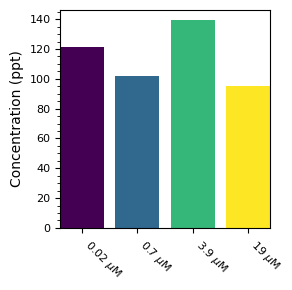

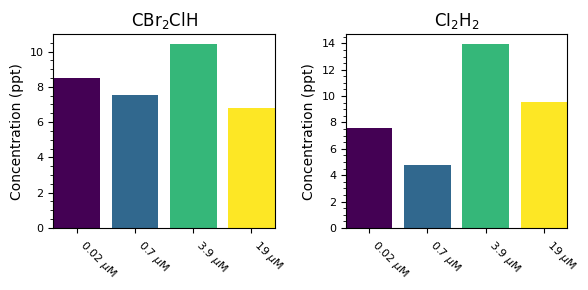

In [45]:
P_conc = [r'0.02 $\mu$M', r'0.7 $\mu$M', r'3.9 $\mu$M', r'19 $\mu$M']

fig, ax = plt.subplots(figsize = (3, 3))
plot_barchart(ax, mean_gcms['Methane, tribromo- Results'], np.zeros(4), P_conc, 'Concentration (ppt)')
fig.tight_layout()
fig.savefig('GC-MS_bromoform.jpg', dpi = 600)

fig1, ax1 = plt.subplots(1,2, figsize = (6, 3))
plot_multi_barchart(ax1, pd.DataFrame({'dibromochloro': mean_gcms['Methane, dibromochloro- Results'], 'diiodo': mean_gcms['Methane, diiodo- Results']}),
                    pd.DataFrame({'dibromochloro': np.zeros(4), 'diiodo': np.zeros(4)}), P_conc, 'Concentration (ppt)')
ax1[0].set(title = 'CBr$_{2}$ClH')
ax1[1].set(title = 'CI$_{2}$H$_{2}$')
fig1.tight_layout()
fig1.savefig('GC-MS_dibromochloro+diiodomethane.jpg', dpi = 600)